In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
pd.set_option('display.max_columns', None)

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv
/kaggle/input/s4e10-data-analysis-and-blending/enhanced_stacking_model.pkl
/kaggle/input/s4e10-data-analysis-and-blending/final_predictions_enhanced.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import seaborn as sns

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
original = pd.read_csv("/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv")

# EDA🧪

In [4]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
original.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
original['loan_int_rate'] = original['loan_int_rate'].fillna(-1)
original['person_emp_length'] = original['person_emp_length'].fillna(-1)


In [8]:
len(original)

32581

In [9]:
train.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [10]:
train = pd.concat([train, original], axis=0)

In [11]:
train.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,91226.000000,9.122600e+04,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000,91226.000000
mean,29322.000000,27.616480,6.477071e+04,4.675882,9350.348607,10.386815,0.163154,5.810219,0.169447
std,16929.497605,6.148115,4.793696e+04,4.044925,5848.605423,3.731106,0.097491,4.038412,0.375149
min,0.000000,20.000000,4.000000e+03,-1.000000,500.000000,-1.000000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.000000e+04,2.000000,5000.000000,7.660000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.700000e+04,4.000000,8000.000000,10.740000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.800000e+04,7.000000,12000.000000,12.990000,0.220000,8.000000,0.000000
max,58644.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [12]:
train.apply(lambda x: x.unique().sum())

id                                                                          NaN
person_age                                                                 2979
person_income                                                         346081459
person_home_ownership                                      RENTOWNMORTGAGEOTHER
person_emp_length                                                         805.0
loan_intent                   EDUCATIONMEDICALPERSONALVENTUREDEBTCONSOLIDATI...
loan_grade                                                              BCADEFG
loan_amnt                                                               9116202
loan_int_rate                                                           5336.38
loan_percent_income                                                      29.804
cb_person_default_on_file                                                    NY
cb_person_cred_hist_length                                                  464
loan_status                             

In [13]:
len(train)

91226

In [14]:
train = train.drop_duplicates()

In [15]:
len(train)

91061

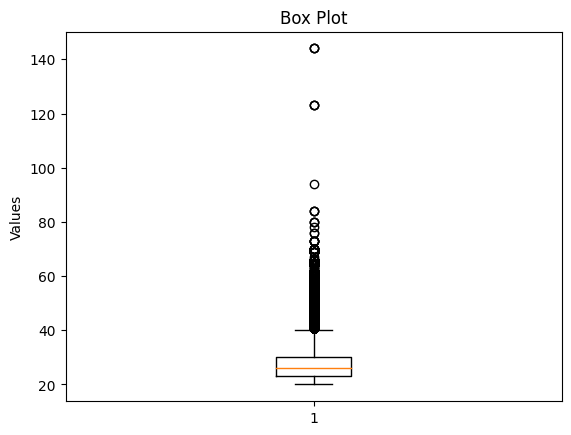

In [16]:
plt.boxplot(train['person_age'])
plt.title('Box Plot')
plt.ylabel('Values')
plt.show()

In [17]:

# Assuming you're working with the column 'Column0'
Q1 = train['person_age'].quantile(0.25)  # 25th percentile (Q1)
Q3 = train['person_age'].quantile(0.95)  # 75th percentile (Q3)
IQR = Q3 - Q1  # Interquartile range (IQR)

# Define bounds
lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Remove outliers
train = train[(train['person_age'] >= lower_bound) & (train['person_age'] <= upper_bound)]

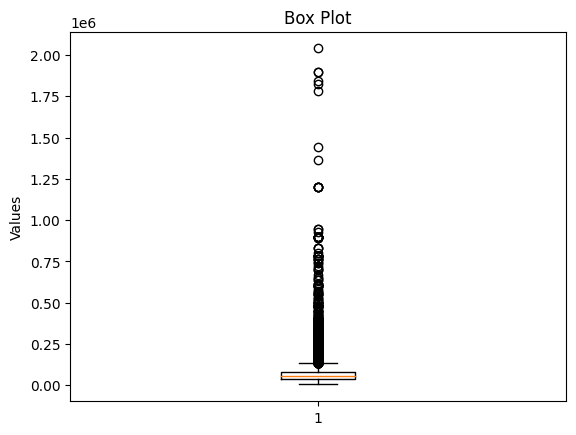

In [18]:
plt.boxplot(train['person_income'])
plt.title('Box Plot')
plt.ylabel('Values')
plt.show()


In [19]:

# Assuming you're working with the column 'Column0'
Q1 = train['person_income'].quantile(0.25)  # 25th percentile (Q1)
Q3 = train['person_income'].quantile(0.84)  # 75th percentile (Q3)
IQR = Q3 - Q1  # Interquartile range (IQR)

# Define bounds
lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Remove outliers
train = train[(train['person_income'] >= lower_bound) & (train['person_income'] <= upper_bound)]


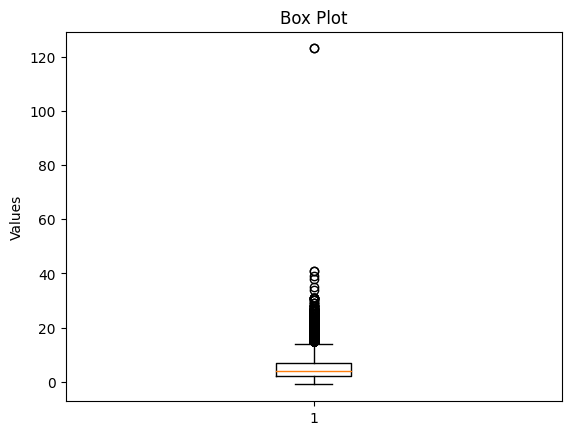

In [20]:
plt.boxplot(train['person_emp_length'])
plt.title('Box Plot')
plt.ylabel('Values')
plt.show()

In [21]:
Q1 = train['person_emp_length'].quantile(0.25)  # 25th percentile (Q1)
Q3 = train['person_emp_length'].quantile(0.98)  # 75th percentile (Q3)
IQR = Q3 - Q1  # Interquartile range (IQR)

# Define bounds
lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Remove outliers
train = train[(train['person_emp_length'] >= lower_bound) & (train['person_emp_length'] <= upper_bound)]

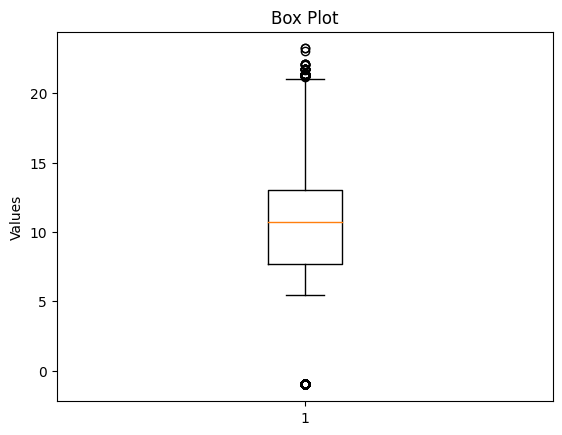

In [22]:
plt.boxplot(train['loan_int_rate'])
plt.title('Box Plot')
plt.ylabel('Values')
plt.show()

In [23]:
# Assuming you're working with the column 'Column0'
Q1 = train['loan_int_rate'].quantile(0.25)  # 25th percentile (Q1)
Q3 = train['loan_int_rate'].quantile(0.84)  # 75th percentile (Q3)
IQR = Q3 - Q1  # Interquartile range (IQR)

# Define bounds
lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Remove outliers
train = train[((train['loan_int_rate'] <= upper_bound))]

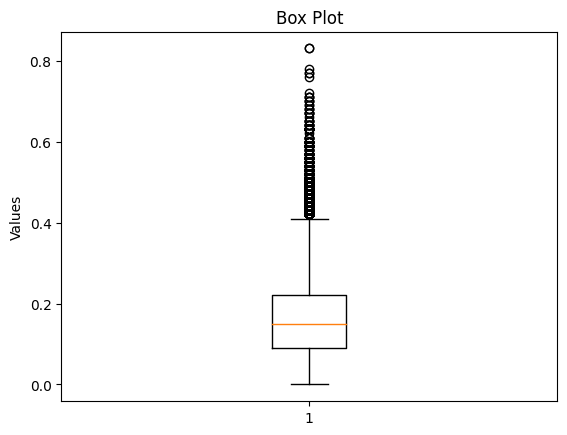

In [24]:
plt.boxplot(train['loan_percent_income'])
plt.title('Box Plot')
plt.ylabel('Values')
plt.show()

In [25]:
# Assuming you're working with the column 'Column0'
Q1 = train['loan_percent_income'].quantile(0.25)  # 25th percentile (Q1)
Q3 = train['loan_percent_income'].quantile(0.96)  # 75th percentile (Q3)
IQR = Q3 - Q1  # Interquartile range (IQR)

# Define bounds
lower_bound = Q1 - 1.4 * IQR
upper_bound = Q3 + 1.4 * IQR

# Remove outliers
train = train[(train['loan_percent_income'] >= lower_bound) & (train['loan_percent_income'] <= upper_bound)]

In [26]:
train['loan_int_rate'] = (train['loan_int_rate'] * 100).astype(int)
train['loan_percent_income'] = (train['loan_percent_income'] * 100).astype(int)


In [27]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,35000,RENT,0.0,EDUCATION,B,6000,1149,17,N,14,0
1,1.0,22,56000,OWN,6.0,MEDICAL,C,4000,1335,7,N,2,0
2,2.0,29,28800,OWN,8.0,PERSONAL,A,6000,890,21,N,10,0
3,3.0,30,70000,RENT,14.0,VENTURE,B,12000,1111,17,N,5,0
4,4.0,22,60000,RENT,2.0,MEDICAL,A,6000,692,10,N,3,0


In [28]:
len(train)

89302

In [29]:
# person_home_ownership, loan_intent, loan_grade, cb_person_default_on_file
ordinal_encoder = OrdinalEncoder()

# Apply it to specific columns that require encoding
columns_to_encode = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
train[columns_to_encode] = ordinal_encoder.fit_transform(train[columns_to_encode])

In [30]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,35000,3.0,0.0,1.0,1.0,6000,1149,17,0.0,14,0
1,1.0,22,56000,2.0,6.0,3.0,2.0,4000,1335,7,0.0,2,0
2,2.0,29,28800,2.0,8.0,4.0,0.0,6000,890,21,0.0,10,0
3,3.0,30,70000,3.0,14.0,5.0,1.0,12000,1111,17,0.0,5,0
4,4.0,22,60000,3.0,2.0,3.0,0.0,6000,692,10,0.0,3,0


In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[['person_income', 'loan_amnt']] = scaler.fit_transform(train[['person_income', 'loan_amnt']])


In [32]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,-0.936338,3.0,0.0,1.0,1.0,-0.565008,1149,17,0.0,14,0
1,1.0,22,-0.189691,2.0,6.0,3.0,2.0,-0.914637,1335,7,0.0,2,0
2,2.0,29,-1.156777,2.0,8.0,4.0,0.0,-0.565008,890,21,0.0,10,0
3,3.0,30,0.308075,3.0,14.0,5.0,1.0,0.483881,1111,17,0.0,5,0
4,4.0,22,-0.047472,3.0,2.0,3.0,0.0,-0.565008,692,10,0.0,3,0


In [33]:
loan_status_counts = train['loan_status'].value_counts()
print(loan_status_counts)

loan_status
0    74000
1    15302
Name: count, dtype: int64


In [34]:
X = train.drop(['id','loan_status'], axis=1)  # Features (exclude the target column)
y = train['loan_status']               # Target variable (the column to predict)

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
10694,23,0.308075,0.0,2.0,1.0,0.0,2.581658,890,34,0.0,4
12864,21,0.841395,0.0,5.0,1.0,1.0,2.756473,1099,28,0.0,2
24886,27,-0.794120,3.0,6.0,0.0,2.0,0.326548,-100,28,1.0,9
44958,22,-0.154136,3.0,0.0,3.0,2.0,-1.456563,1141,2,0.0,4
47497,25,0.308075,0.0,9.0,5.0,0.0,-0.739823,542,7,0.0,3


# Models 🤖

In [36]:
from xgboost import XGBClassifier
xgb_params = {'n_estimators': 1029, 'max_depth': 6, 'learning_rate': 0.06367122004481496, 'gamma': 0.16037122453355343, 'min_child_weight': 6, 'colsample_bytree': 0.8801134322091964}
model = XGBClassifier(                    
**xgb_params)

XGB = model.fit(
    X_train, 
    y_train,)

In [37]:
feature_importances = XGB.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [0.01258601 0.05983136 0.19962686 0.03099822 0.07465602 0.3858036
 0.03799849 0.02783127 0.15190047 0.00980166 0.00896604]


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14799
           1       0.94      0.75      0.84      3062

    accuracy                           0.95     17861
   macro avg       0.95      0.87      0.90     17861
weighted avg       0.95      0.95      0.95     17861



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


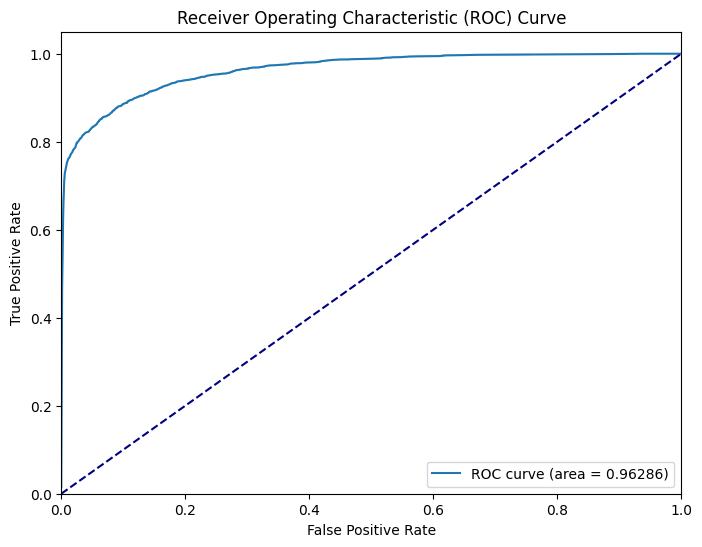

In [38]:
y_prob = XGB.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = XGB.predict(X_test)
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
from catboost import CatBoostClassifier

params = {
        'iterations': 4336, 
        'learning_rate': 0.14427237122584682, 
        'depth': 5, 
        'l2_leaf_reg': 9.390043452397858,
        'random_seed': 42,  # Keep the random seed fixed for reproducibility
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': 0
    }

catboost_model = CatBoostClassifier(
    **params
)

catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds
    verbose=True
)

0:	test: 0.8727776	best: 0.8727776 (0)	total: 68.8ms	remaining: 4m 58s
1:	test: 0.8762623	best: 0.8762623 (1)	total: 82.9ms	remaining: 2m 59s
2:	test: 0.8853737	best: 0.8853737 (2)	total: 95.5ms	remaining: 2m 17s
3:	test: 0.8967670	best: 0.8967670 (3)	total: 108ms	remaining: 1m 57s
4:	test: 0.8974917	best: 0.8974917 (4)	total: 121ms	remaining: 1m 44s
5:	test: 0.9003296	best: 0.9003296 (5)	total: 134ms	remaining: 1m 36s
6:	test: 0.9036824	best: 0.9036824 (6)	total: 146ms	remaining: 1m 30s
7:	test: 0.9057943	best: 0.9057943 (7)	total: 159ms	remaining: 1m 25s
8:	test: 0.9056794	best: 0.9057943 (7)	total: 172ms	remaining: 1m 22s
9:	test: 0.9122286	best: 0.9122286 (9)	total: 184ms	remaining: 1m 19s
10:	test: 0.9120957	best: 0.9122286 (9)	total: 197ms	remaining: 1m 17s
11:	test: 0.9155049	best: 0.9155049 (11)	total: 210ms	remaining: 1m 15s
12:	test: 0.9162230	best: 0.9162230 (12)	total: 223ms	remaining: 1m 14s
13:	test: 0.9170991	best: 0.9170991 (13)	total: 236ms	remaining: 1m 12s
14:	test: 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14799
           1       0.93      0.76      0.84      3062

    accuracy                           0.95     17861
   macro avg       0.94      0.87      0.90     17861
weighted avg       0.95      0.95      0.95     17861



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


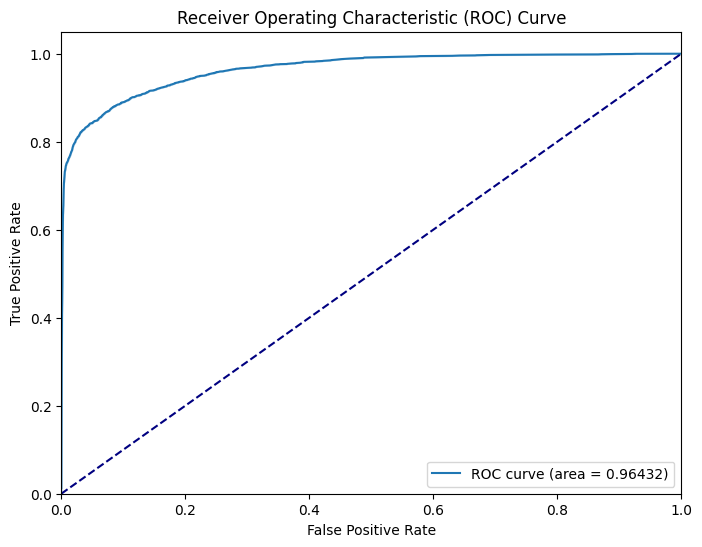

In [40]:
y_prob = catboost_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = catboost_model.predict(X_test)
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [41]:
import lightgbm as lgb


params = {
            'learning_rate': 0.061862664980661994, 
           'n_estimators': 332, 
            'max_depth': 50, 
             'reg_alpha': 0.7323407518566067, 
         'reg_lambda': 2.812933063217073, 
         'num_leaves': 98, 
         'colsample_bytree': 0.5554050799203062,
        'n_jobs': -1,
        'verbose': -1
    }
lgbm = lgb.LGBMClassifier(**params)
lgbm.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.5554050799203062,
               learning_rate=0.061862664980661994, max_depth=50,
               n_estimators=332, n_jobs=-1, num_leaves=98,
               reg_alpha=0.7323407518566067, reg_lambda=2.812933063217073,
               verbose=-1)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14799
           1       0.94      0.76      0.84      3062

    accuracy                           0.95     17861
   macro avg       0.94      0.87      0.90     17861
weighted avg       0.95      0.95      0.95     17861



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


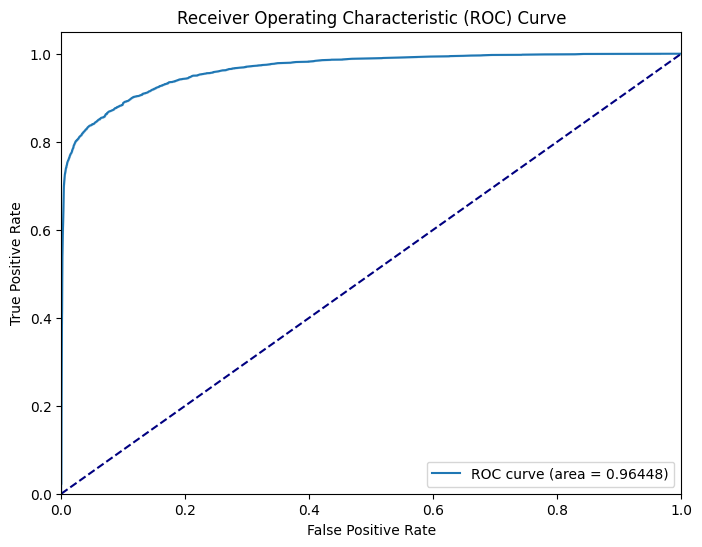

In [42]:
y_prob = lgbm.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = lgbm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

params = {
    'n_estimators': 890,
    'learning_rate': 0.0798733588220119, 
    'max_depth': 5, 
    'min_samples_split': 10, 
    'min_samples_leaf': 3, 
    'subsample': 0.9744710799211628, 
    'max_features': None,
    'random_state': 42  # Keep it fixed for reproducibility
}

gbm = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=6, n_estimators=500,
                           random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14799
           1       0.93      0.76      0.84      3062

    accuracy                           0.95     17861
   macro avg       0.94      0.87      0.90     17861
weighted avg       0.95      0.95      0.95     17861



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


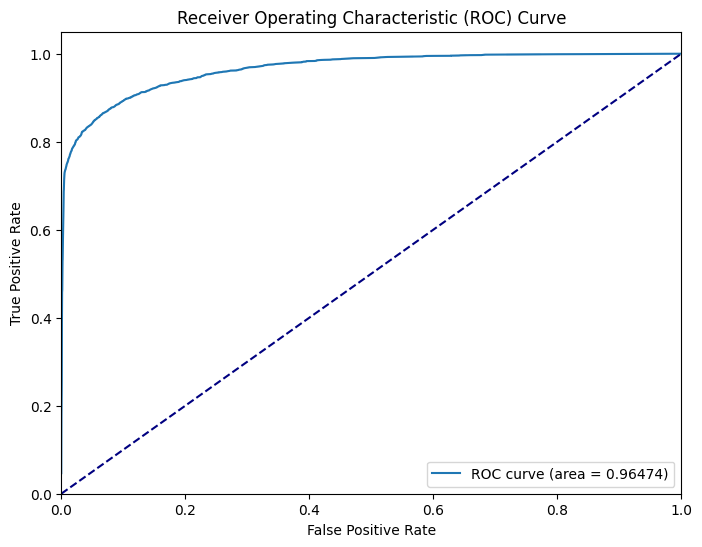

In [44]:
y_prob = gbm.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = gbm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
from sklearn.ensemble import HistGradientBoostingClassifier
hist_gbm = HistGradientBoostingClassifier(max_iter=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
hist_gbm.fit(X_train, y_train)


HistGradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_iter=1000,
                               random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     14799
           1       0.94      0.75      0.83      3062

    accuracy                           0.95     17861
   macro avg       0.95      0.87      0.90     17861
weighted avg       0.95      0.95      0.95     17861



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


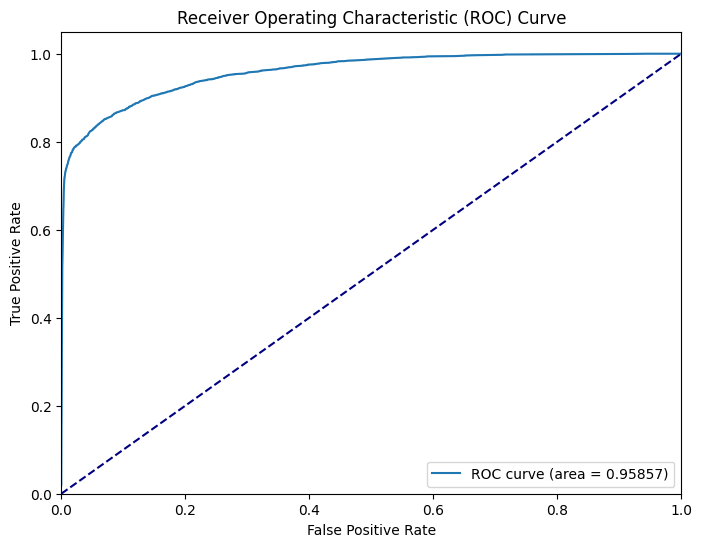

In [46]:
y_prob = hist_gbm.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = hist_gbm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Infrence 🔮

In [47]:
df = pd.DataFrame()
df['lgbm'] = lgbm.predict_proba(X_test)[:, 1]
df['brf'] = catboost_model.predict_proba(X_test)[:, 1]
df['bbc'] = gbm.predict_proba(X_test)[:, 1]
df['XGB'] = XGB.predict_proba(X_test)[:, 1]
df['anc'] = hist_gbm.predict_proba(X_test)[:, 1]

In [48]:
df['final_output'] = df[['lgbm', 'XGB', 'bbc','brf']].mean(axis=1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


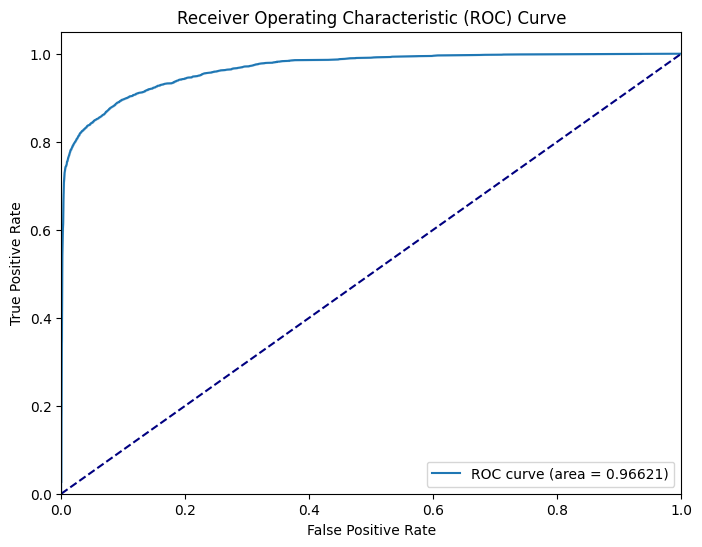

In [49]:
y_prob = df['final_output']  # Probabilities for class 1
# y_pred = lgbm.predict(X_test)

# # Classification report
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [50]:
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

In [51]:
public_notebook = pd.read_csv("/kaggle/input/s4e10-data-analysis-and-blending/final_predictions_enhanced.csv")

In [52]:
public_notebook.head()

,id,loan_status
0,58645,0.929169
1,58646,0.026868
2,58647,0.433073
3,58648,0.013023
4,58649,0.040572


In [53]:
# preprocess(test)

In [54]:
test[columns_to_encode] = ordinal_encoder.transform(test[columns_to_encode])
test[['person_income','loan_amnt']] = scaler.transform(test[['person_income','loan_amnt']])

In [55]:
test['loan_int_rate'] = (test['loan_int_rate'] * 100).astype(int)
test['loan_percent_income'] = (test['loan_percent_income'] * 100).astype(int)

In [56]:
final = test.drop('id', axis=1)

In [57]:
# Get predicted probabilities for each model
test['lgbm'] = lgbm.predict_proba(final)[:, 1]  # Probability of class 1
test['brf'] = catboost_model.predict_proba(final)[:, 1]    # Probability of class 1
test['bbc'] = gbm.predict_proba(final)[:, 1] 
test['XGB'] = XGB.predict_proba(final)[:, 1] 
test['public'] = public_notebook['loan_status']# Probability of class 1
# test['anc'] = model.predict(final).ravel()


In [58]:
test['loan_status'] = test[['lgbm', 'XGB', 'bbc','brf','public']].mean(axis=1)

# # Print the updated DataFrame
# print(test.head())

In [59]:
submission = test[['id','loan_status']]

In [60]:
submission.head()

,id,loan_status
0,58645,0.984872
1,58646,0.032013
2,58647,0.428159
3,58648,0.009508
4,58649,0.041707


In [61]:
# Save the first few rows (head) of the 'submission' DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)